## Importing Libraries

In [1]:
import os
import keras
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


## EDA

In [2]:
df=pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df=df.drop('Time',axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [3]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values 

In [6]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

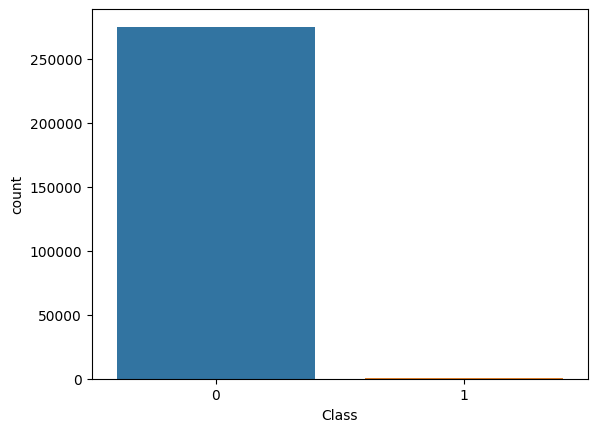

In [7]:
sns.countplot(data=df,x='Class')

In [8]:
df.drop('Class',axis=1).skew()

V1        -3.273070
V2        -4.653486
V3        -2.216730
V4         0.681387
V5        -2.458790
V6         1.867576
V7         2.877722
V8        -8.292631
V9         0.550965
V10        1.242165
V11        0.347772
V12       -2.208171
V13        0.061058
V14       -1.953613
V15       -0.295836
V16       -1.048371
V17       -3.802987
V18       -0.255710
V19        0.115957
V20       -2.045060
V21        2.784302
V22       -0.200868
V23       -5.805236
V24       -0.545636
V25       -0.408260
V26        0.587603
V27       -0.745732
V28       11.400938
Amount    16.841622
dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Amount', ylabel='Density'>

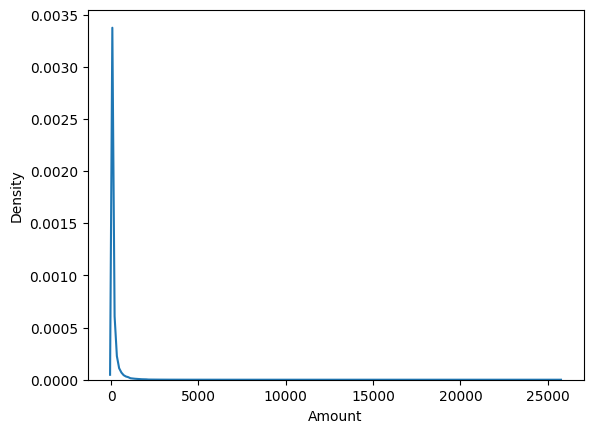

In [9]:
sns.kdeplot(df['Amount'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Amount', ylabel='Density'>

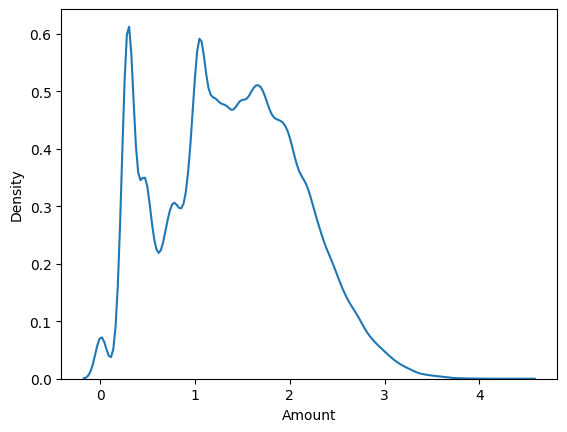

In [10]:
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
sns.kdeplot(df['Amount'])

## Creating a sub sample

What - create a[](http://) df with equal number of fraud and non fraud samples  
Why - Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the target. By having an imbalance dataframe we are not able to see the true correlations between the class and features

In [11]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

subsample = pd.concat([fraud_df, non_fraud_df])
new_df = subsample.sample(frac=1, random_state=42)

### Correlation

In [12]:
corr = df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

In [13]:
corr = new_df.corr()
fig=px.imshow(corr, aspect="auto" ,color_continuous_scale='RdBu_r')
fig.show()

Negative Correlations: V17, V14, V12 and V10 are negatively correlated.  
Positive Correlations: V2, V4, V11 are positively correlated.

### TSNE

In [14]:
from sklearn.manifold import TSNE
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

In [15]:
fig=px.scatter(x=X_reduced_tsne[:,0], y=X_reduced_tsne[:,1], color=y)
fig.show()

Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately

## Scaling

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

[LightGBM] [Info] Number of positive: 378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 220530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001714 -> initscore=-6.367179
[LightGBM] [Info] Start training from score -6.367179
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.26      0.44      0.33        95

    accuracy                           1.00     55133
   macro avg       0.63      0.72      0.66     55133
weighted avg       1.00      1.00      1.00     55133



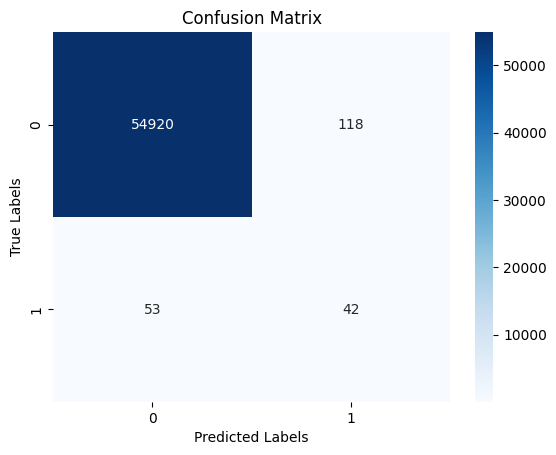

In [18]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# GAN

Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.82      0.66      0.73        95

    accuracy                           1.00     55133
   macro avg       0.91      0.83      0.87     55133
weighted avg       1.00      1.00      1.00     55133



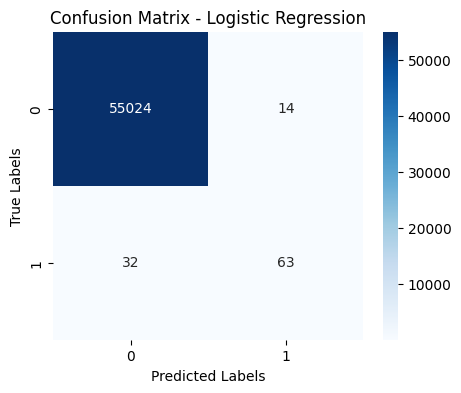

Training Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.63      0.75      0.69        95

    accuracy                           1.00     55133
   macro avg       0.82      0.87      0.84     55133
weighted avg       1.00      1.00      1.00     55133



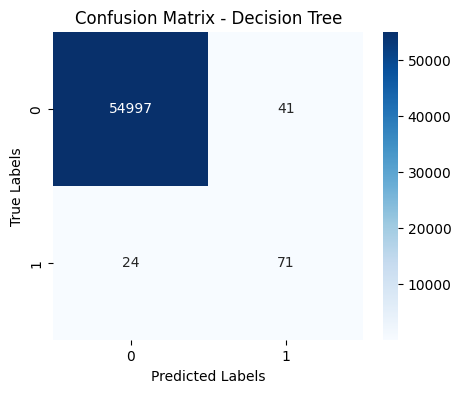

Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.92      0.81      0.86        95

    accuracy                           1.00     55133
   macro avg       0.96      0.91      0.93     55133
weighted avg       1.00      1.00      1.00     55133



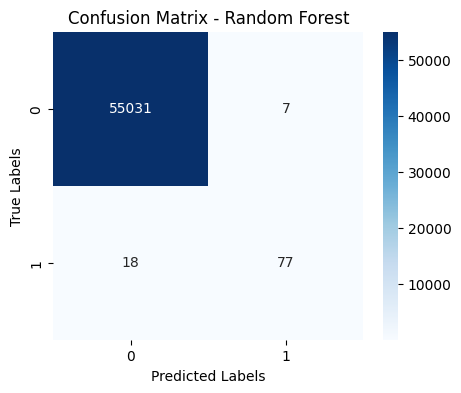

Training K-Nearest Neighbors...

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.91      0.77      0.83        95

    accuracy                           1.00     55133
   macro avg       0.96      0.88      0.92     55133
weighted avg       1.00      1.00      1.00     55133



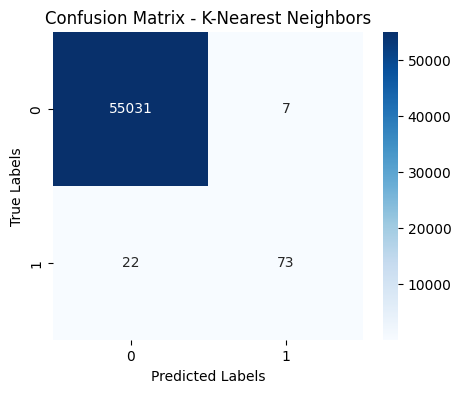

Training Gradient Boosting...

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.56      0.79      0.66        95

    accuracy                           1.00     55133
   macro avg       0.78      0.89      0.83     55133
weighted avg       1.00      1.00      1.00     55133



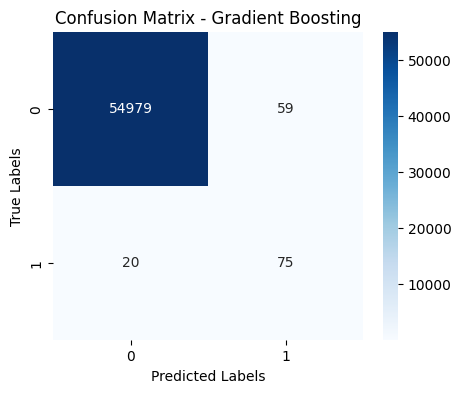

Training XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.94      0.82      0.88        95

    accuracy                           1.00     55133
   macro avg       0.97      0.91      0.94     55133
weighted avg       1.00      1.00      1.00     55133



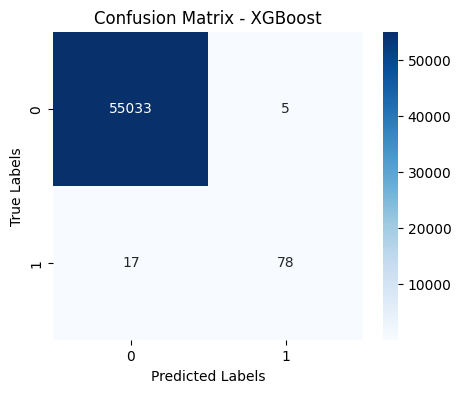

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=5),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=5),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## Conditional GAN Architecture

In [20]:
class cGAN(): #Conditional GAN
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.num_classes = 2
    
        # Optimizer
        optimizer = Adam(0.0002, 0.5)
    
        # Build discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
    
        # Build generator
        self.generator = self.build_generator()
    
        # Generate samples
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
    
        # Freeze discriminator for combined model
        self.discriminator.trainable = False
    
        # Discriminator prediction for combined model
        valid = self.discriminator([gen_samples, label])
    
        # Build combined model
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=Adam(0.0002, 0.5),  # Recreate optimizer
                              metrics=['accuracy'])
        self.combined.summary()


    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02) #initialization of weights of layer
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim)) #gets a random vector with dim 32 as IP
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh')) #OP tensor which will be stored in gen_sample
        model.summary()

        noise = Input(shape=(self.latent_dim,)) 
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label)) #convert labels(0 and 1) into vector having same dim as noise
        
        model_input = multiply([noise, label_embedding]) #Element-wise Multiplication
        gen_sample = model(model_input) #passing data to model created using Sequential

        return Model([noise, label], gen_sample, name="Generator") #IP-[noise, label],OP-gen_sample

    
    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        
        gen_sample = Input(shape=(self.out_shape,)) #input data sample (real or fake)
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label)) #convert 0 and 1 into vector having same dim as out_shape

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input) #passing data to model and prediction of disc

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator") #used for mul inputs/outputs
        #We need to specify the input and output tensor
        #Model has Attributes such as compile,fit,evaluvate,predict
    


    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50): #Frequency of logging progress during training

        # Adversarial ground truths
        valid = np.ones((batch_size, 1)) #for real samples
        fake = np.zeros((batch_size, 1)) #for fake samples

        for epoch in range(epochs):
            
            #  Train Discriminator with 8 sample from postivite class and rest with negative class 
            idx1 = np.random.choice(pos_index, 8) #if we use raw distribution disc mostly train on non-fraud label which makes it biased?
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim)) #creates the noise vector

            # Generate a half batch of new images
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing - adding noise to ground truth labels during intial stage to reduce confidence of disc?
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid 
                fake_smooth = fake
                
            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth) 
            #lower-level training method compared to the higher-level fit method, offering more control and flexibility, returns scalar loss value
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #avg of 2 losses

            # Train Generator
            # Condition on labels
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1) #generator learns to produce data for both class?
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid) #target valid-our goal is to make disc predict fake as real so all ones

            # Plot the progress
            if (epoch+1)%sample_interval==0:
                print (f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [21]:
cgan = cGAN() #Initialize 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 179,713 (702.00 KB)

 Trainable params: 179,713 (702.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 29)                  │          14,877 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,293 (731.61 KB)

 Trainable params: 185,501 (724.61 KB)

 Non-trainable params: 1,792 (7.00 KB)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 32)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Generator (Functional)    │ (None, 29)             │        187,357 │ input_layer_6[0][0],   │
│                           │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Discriminator             │ (None, 1)              │        179,771 │ Generator[0][0],       │
│ (Functional)              │                        │                │ input_layer_7[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 367,128 (1.40 MB)

 Trainable params: 185,565 (724.86 KB)

 Non-trainable params: 181,563 (709.23 KB)

## Training GAN

In [22]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=1000)

from IPython.display import clear_output
clear_output()

## Generating new samples

In [23]:
noise = np.random.normal(0, 1, (250000, 32))
sampled_labels = np.ones(250000).reshape(-1, 1) #ones in order to only fraud data

gen_samples = cgan.generator.predict([noise, sampled_labels])
gen_samples = scaler.inverse_transform(gen_samples)
print(gen_samples.shape)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
(250000, 29)


In [24]:
gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('Class',axis=1).columns)
gen_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.663507,1.650600,1.516803,-1.362302,1.365082,-0.036460,1.242880,-1.191067,0.157792,1.061559,...,0.378137,0.735489,0.720678,-0.516889,-0.526874,0.515336,-0.270699,-0.354726,0.324124,1.949466
1,-1.985551,1.661122,1.530215,-0.330294,1.251863,1.225582,0.863809,-1.147043,0.820499,1.085246,...,0.473578,0.111192,0.731075,-0.100488,-0.610733,0.518719,-0.481501,-0.194325,0.332322,2.103885
2,-1.920770,1.662880,1.528515,-1.201573,1.363633,0.959350,1.248036,-1.182191,0.142869,1.090068,...,0.683045,0.735497,0.716564,-0.082543,-0.246694,0.518092,-0.272835,-0.393995,0.329403,2.086105
3,-1.975265,-1.636595,1.521666,0.978589,0.681256,0.636761,-1.230965,-1.074704,0.753170,-1.062332,...,0.254978,0.705059,0.731553,-0.120159,-0.612081,0.517301,-0.483762,0.400913,0.245825,2.104473
4,-1.952642,1.662356,1.519110,-0.161380,1.362689,1.215827,1.235179,-1.188903,1.031538,1.087477,...,0.630390,0.735462,0.731045,-0.417303,-0.584172,0.519186,-0.471753,-0.375206,0.328473,2.100720


In [25]:
gen_X_train = np.concatenate((X_train, gen_samples), axis=0)
gen_X_train.shape

(470530, 29)

In [26]:
gen_y = np.ones((250000, 1))
gen_y_train = np.concatenate((y_train, gen_y), axis=0)
gen_y_train.shape

(470530, 1)

## Testing baseline model with generated data

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Number of positive: 250378, number of negative: 220152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 470530, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532119 -> initscore=0.128654
[LightGBM] [Info] Start training from score 0.128654
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.58      0.78      0.66        95

    accuracy                           1.00     55133
   macro avg       0.79      0.89      0.83     55133
weighted avg       1.00      1.00      1.00     55133



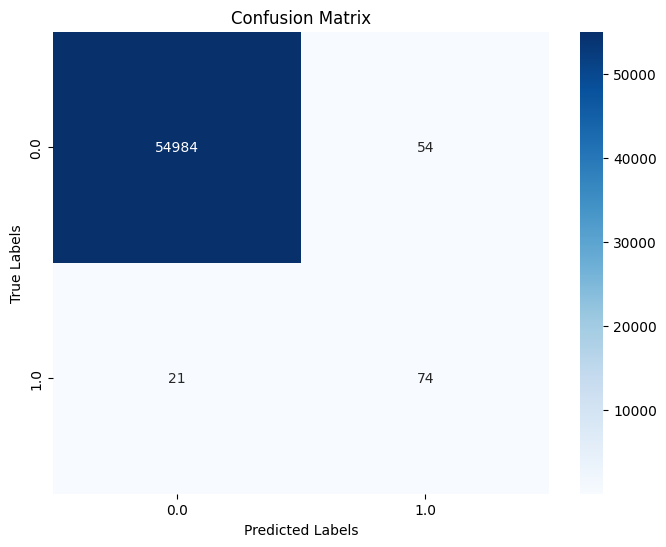

In [27]:
model = lgb.LGBMClassifier()
model.fit(gen_X_train, gen_y_train)

y_pred = model.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     55038
           1       0.06      0.79      0.12        95

    accuracy                           0.98     55133
   macro avg       0.53      0.88      0.55     55133
weighted avg       1.00      0.98      0.99     55133



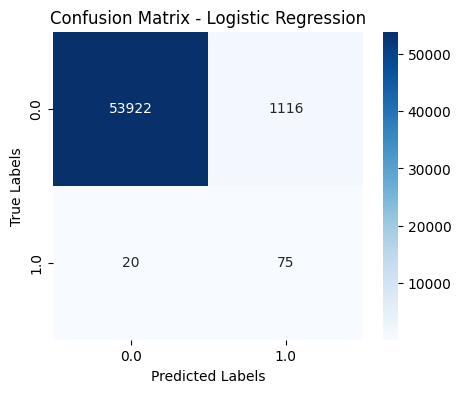

Training Decision Tree...

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.45      0.72      0.55        95

    accuracy                           1.00     55133
   macro avg       0.72      0.86      0.77     55133
weighted avg       1.00      1.00      1.00     55133



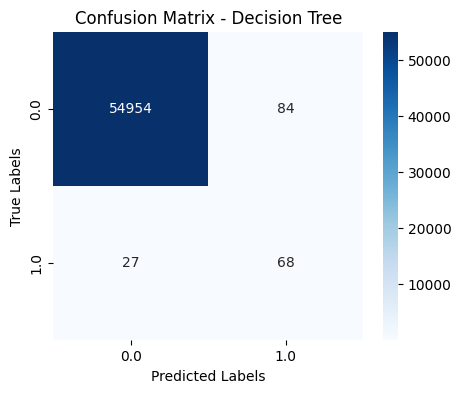

Training Random Forest...


<ipython-input-28-4f0cc70a4797>:26: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.95      0.76      0.84        95

    accuracy                           1.00     55133
   macro avg       0.97      0.88      0.92     55133
weighted avg       1.00      1.00      1.00     55133



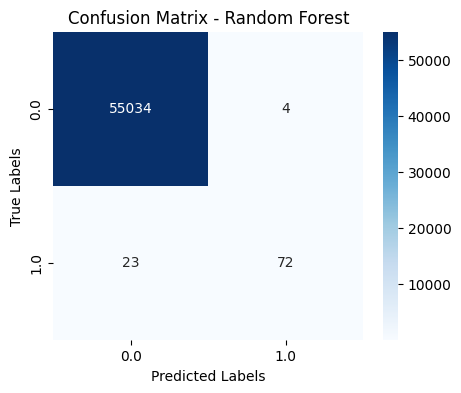

Training K-Nearest Neighbors...


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.91      0.74      0.81        95

    accuracy                           1.00     55133
   macro avg       0.95      0.87      0.91     55133
weighted avg       1.00      1.00      1.00     55133



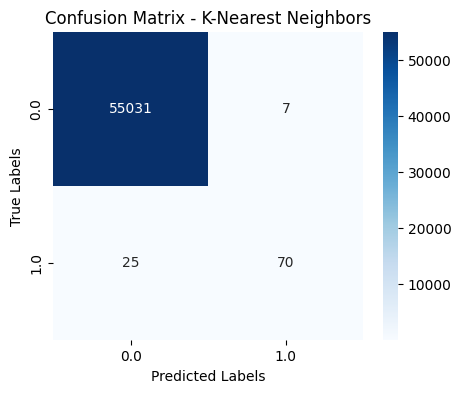

Training Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.01      0.03      0.02        95

    accuracy                           0.99     55133
   macro avg       0.50      0.51      0.51     55133
weighted avg       1.00      0.99      1.00     55133



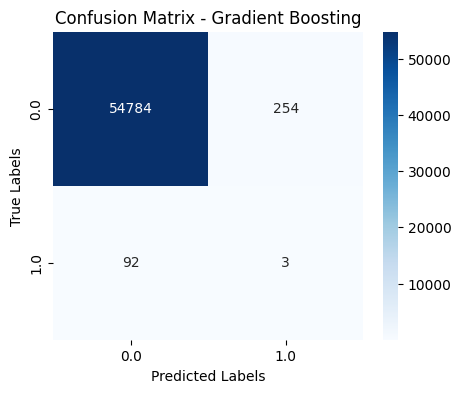

Training XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55038
           1       0.93      0.84      0.88        95

    accuracy                           1.00     55133
   macro avg       0.96      0.92      0.94     55133
weighted avg       1.00      1.00      1.00     55133



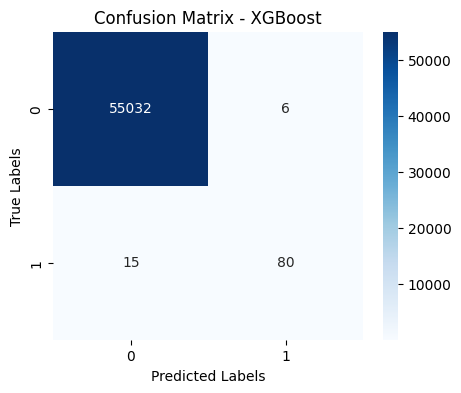

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=20),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=10),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(gen_X_train, gen_y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# Autoencoder

In [29]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv').drop('Time', axis=1)

In [30]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, stratify=df['Class'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2, stratify=train_df['Class']) 
#distribution of a specified column is preserved in both the training and testing datasets
y_train = train_df.pop('Class').values
y_val = val_df.pop('Class').values
y_test = test_df.pop('Class').values

In [31]:
qt_transform = QuantileTransformer(output_distribution='normal')
X_train = qt_transform.fit_transform(train_df)
X_val = qt_transform.transform(val_df)
X_test = qt_transform.transform(test_df)

## Autoencoder Architecture

In [32]:
def encoder(inputs): #input tensor and dic with controlable params
    x = inputs
    for i in range(3): #number of hidden layers
        x = keras.layers.Dense(128//2**i, activation=None, name=f'encoder_dense_{i}')(x) #number of neurons half each time
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU(0.2)(x)
        x = keras.layers.Dropout(0.05)(x)
        
    # final bottleneck layer
    x = keras.layers.Dense(16, activation=None, name='bottleneck')(x)
    return x

def decoder(inputs, input_dim):
    x = inputs
    
    for i in range(3):
        x = keras.layers.Dense(128//2**(2-i), activation=None, name=f'decoder_dense_{i}')(x) ##number of neurons double each time
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        x = keras.layers.Dropout(0.05)(x)
    # output
    x = keras.layers.Dense(input_dim, activation=None)(x)
    return x

def dense_autoencoder(input_dim):
    inputs = keras.Input(shape=(input_dim,)) #Used to instantiate a input Keras tensor
    encoder_output = encoder(inputs)
    decoder_output = decoder(encoder_output, input_dim) #Output Keras tensor
    
    model = keras.Model(inputs=inputs, outputs=decoder_output) #Input and output tensor is enough to build the model
    
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.01,
        ),
        loss='mean_squared_error'
    )

    return model

In [33]:
keras.backend.clear_session() #optional
ae_model = dense_autoencoder(X_train.shape[1]) #29 cols
ae_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_0 (Dense)              │ (None, 128)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_1 (Dense)              │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense_2 (Dense)              │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_0 (Dense)              │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense_1 (Dense)              │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 31,213 (121.93 KB)

 Trainable params: 30,317 (118.43 KB)

 Non-trainable params: 896 (3.50 KB)

## Training Autoencoder

In [34]:
EPOCHS = 100
BATCH_SIZE = 256
    
# callbacks - reduce lr on plateau and early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min', # looks for lowest value of val loss 
    verbose=True, # prints a msg when early halt is triggered
    patience=15, # continuous for next 15 epochs after the lowest val loss 
    restore_best_weights=True # weights of the lowest loss will be used for model
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=True,
    patience=5,
    factor= 0.1, #if the current learning rate is 0.01 and the factor is 0.1, the new learning rate will be 0.001
    min_lr = 1e-5 #Sets a lower bound for the learning rate
)

history = ae_model.fit(
    X_train[y_train==0,:], # filtering out non-fraudulant data and used for training
    X_train[y_train==0,:], # here we are reconstructing the I/P so target will be same as input 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks = [early_stopping, reduce_lr], 
    validation_data=(X_val[y_val==0], X_val[y_val==0])
)

Epoch 1/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.4824 - val_loss: 0.1641 - learning_rate: 0.0100
Epoch 2/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2406 - val_loss: 0.1283 - learning_rate: 0.0100
Epoch 3/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2140 - val_loss: 0.1026 - learning_rate: 0.0100
Epoch 4/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2047 - val_loss: 0.0935 - learning_rate: 0.0100
Epoch 5/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1972 - val_loss: 0.0910 - learning_rate: 0.0100
Epoch 6/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1921 - val_loss: 0.0858 - learning_rate: 0.0100
Epoch 7/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1883 - val_loss: 0.0796 - learning_rate: 0.0100
Epoch 8/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1823 - val_loss: 0.0761 - learning_rate: 0.0100
Epoch 9/100
711/711 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1785 - val_loss: 0.0688 - learning_rate: 0.0100
E

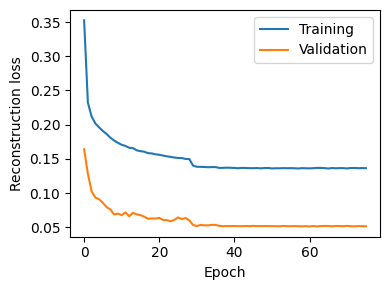

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(4,3))

graph = axs.plot(history.epoch, history.history['loss'], label='Training')
graph = axs.plot(history.epoch, history.history['val_loss'], label='Validation')                 
graph = axs.legend()
graph = axs.set_xlabel('Epoch')
graph = axs.set_ylabel('Reconstruction loss')
fig.tight_layout()

## Defining Reconstruction loss

In [36]:
def get_reconst_loss(X):
    X_reconst = ae_model.predict(X, batch_size=256)
    return (
        ((X-X_reconst)**2).sum(axis=1)
    )

### Plotting Reconstruction loss for fraud and non-fraud transactions

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



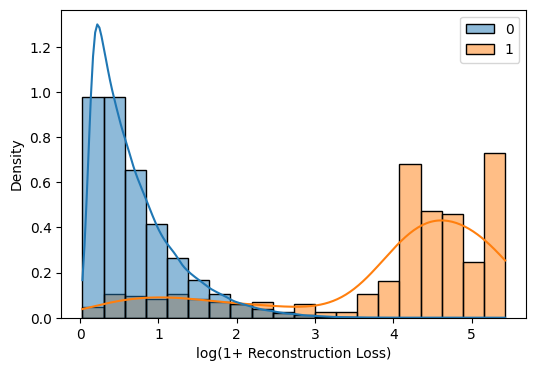

In [37]:
reconst_train = get_reconst_loss(X_train)

fig, ax = plt.subplots(1,1, figsize=(6,4))
graph = sns.histplot(
    x=np.log1p(reconst_train), #applies log(1+x) transformation,for stabilizing skewed distributions
    hue=y_train,
    bins=20, 
    stat='density', #Normalizes the histogram to show a density curve instead of raw counts
    kde=True, 
    common_norm=False,
    alpha = 0.5, #Sets transparency for the histogram bars
    ax=ax
)
graph = ax.set_xlabel('log(1+ Reconstruction Loss)')

We are training the autoencoder only on the non-fraud samples so it minimizes the reconstruction loss during training by extracting the main features and reconstructing it. But when we pass a fraud transaction whose main features are different from non-fraud, the reconstruction loss will be high. So we can define a thereshold to classify fraud and non-fraud transactions

In [38]:
reconst_val = get_reconst_loss(X_val)
reconst_test = get_reconst_loss(X_test)

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Thershold for reconstruction error - As we decrease the thereshold the chance of predicting fraud transaction increases but number of false alarm also increases so we need to decide the sweet spot for the thereshold  
Usually, not identifying a fradulent transacation is considered more costly than raising a false alarm

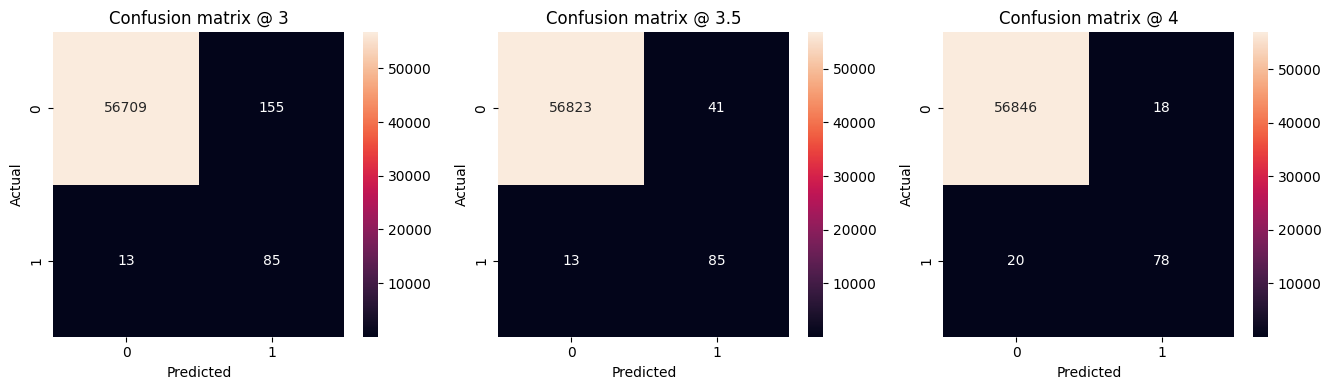

In [39]:
thresholds = [3, 3.5, 4]

fig, axs = plt.subplots(1, len(thresholds), figsize=(4.5*len(thresholds), 4))
for i, threshold in enumerate(thresholds):
    _ = sns.heatmap(confusion_matrix(y_test, np.log1p(reconst_test) > threshold), annot=True, ax=axs[i], fmt='g')
    _ = axs[i].set_ylabel('Actual')
    _ = axs[i].set_xlabel('Predicted')
    _ = axs[i].set_title(f'Confusion matrix @ {threshold}')
    
fig.tight_layout()